In [1]:
## Reloading packages
%load_ext autoreload
%autoreload 2

## Adding 'FDS profiling package'
import sys
sys.path.insert(0, '/Users/harsh/Desktop/DATA_SCIENCE/PandasProfiling/')

## Packages
import requests
import io

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from missingno import missingno
from fds_profiling.visualisation.image_encoding import hex_to_rgb, plot_360_n0sc0pe

from fds_profiling.report import templates
from fds_profiling.report.renderable import Renderable

from fds_profiling.config import config

from fds_profiling.model.variable_types import get_df_var_types

from fds_profiling.model.aggregators import groupby_aggregator, count_metric
from fds_profiling.model.summary import describe_numeric_1d
from fds_profiling.model.summary import get_table_stats
from fds_profiling.model.describe import describe_dataframe
from fds_profiling.model.associations import associations
from fds_profiling.visualisation.charts import bar_chart, histogram

/Users/harsh/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# describe_numeric_1d(df["Age"])

##### Titanic dataset

In [3]:
s = requests.get("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv").content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

## Metrics
#### TODO: space problem in metric name
def count_(df):
    return df

def metric_1(df):
    return df["Survived"].sum()

def metric_2(df):
    return df["Survived"].count()

total_metrics = [("metric_1", metric_1), ("metric_2", metric_2)]

In [4]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


##### Variable types

In [5]:
config.config["var_types"] = get_df_var_types(df)
column_types = config.config["var_types"]

#### Report Structure

In [6]:
# df.describe()

In [7]:
sections = []

## Section: Overview
df_info = describe_dataframe(df, config.config["var_types"])
sections.append(
    Renderable(
        content = {
            "size": 6,
            "headings": ["Dataset statistics", "Variable types"],
            "contents": df_info
        },
        name="Overview",
        anchor_id="overview",
        type_id="multiple_tables"))

## Variables
sections.append(
    Renderable(
        content = {"dataframe":df, "metrics":total_metrics, "column_types":config.config["var_types"]},
        name="Variables",
        anchor_id="variables",
        type_id="variables_container"))

# Missing values
sections.append(
    Renderable(
        content = {"dataframe":df},
        name="Missing values",
        anchor_id="missing_values",
        type_id="missing_container"))

##### Creating HTML report

In [8]:
## Creating
html_template = templates.template("report.html")

#### navigations items
nav_items = [
    (section.name, section.anchor_id)
    for section in sections
]

## TODO (default title)
data = html_template.render(
    title = "FDS PROFILING", ## report
    nav_items=nav_items, ## navigation
    sections=sections, ## report (content)
)

## Writing
with open("sample_profiles/harsh_profiling.html", "w") as file:
    file.write(data)

# #

#### Data creation

In [280]:
## Associations
associations_df = associations(df, column_types)

In [281]:
associations_df.head(2)

,col_a,association,col_b,type_
110,Fare,0.59,Pclass,NUM-CAT
33,Pclass,0.59,Fare,CAT-NUM


In [282]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


#### Networkx

##### Importing

In [359]:
import networkx as nx

##### Creating a graph

In [360]:
# G = nx.Graph()

# ## Creating node
# for column in df.columns:
#     G.add_node(column)

# ## Adding edges
# G.add_edge("Ticket", "Fare")

# ## Visualize
# nx.draw(G, with_labels=True)

In [371]:
# Using pandas dataframe
G = nx.from_pandas_edgelist(associations_df[associations_df["association"] > .1], "col_a", 'col_b', edge_attr="association")

# ## Creating node
for column in df.columns:
    G.add_node(column)

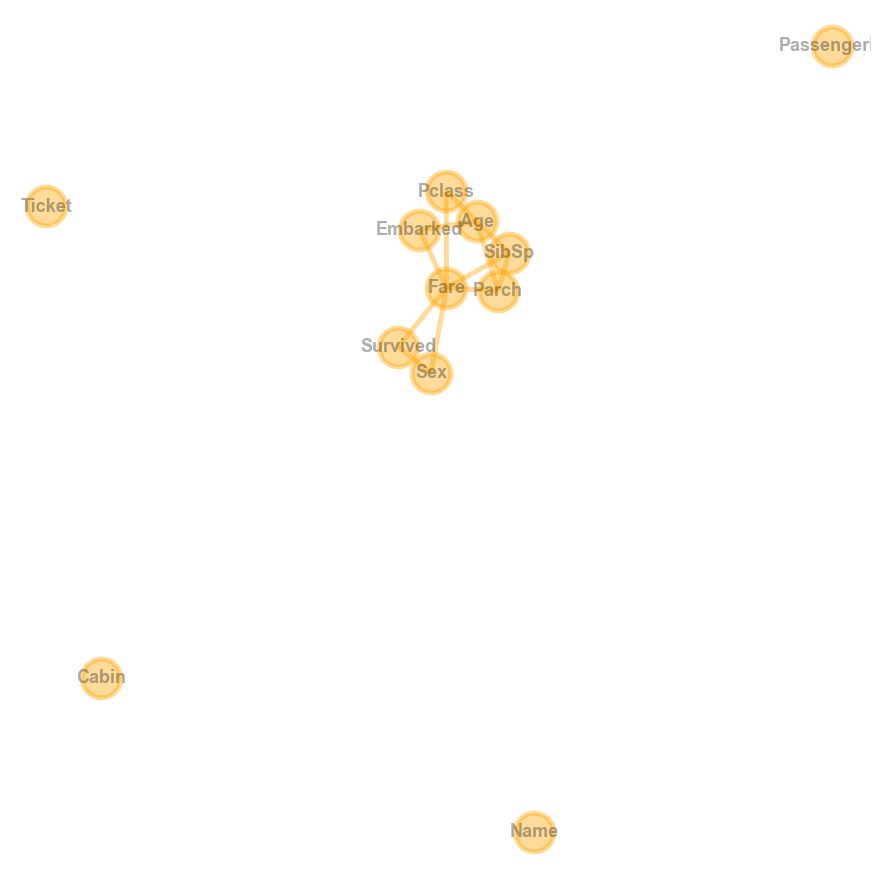

In [375]:
# Graph with Custom nodes:
plt.figure(figsize=(12, 12))
nx.draw(G,
        with_labels=True,
        pos=nx.spring_layout(G, iterations=50),
        
        # node customizations
        node_size=1500,
        node_color="orange",
        node_shape="o",
        alpha=0.4,
        linewidths=5,
        
        # label customization
        font_size=18,
        font_color="#333333",
        font_weight="bold",
        
        # edge customization
        width=5,
        edge_color="orange",
        style="solid"
       )

plt.show()

In [376]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 12))

# # 1. Create the graph
# G = nx.from_pandas_edgelist(associations_df.head(5), "col_a", 'col_b', edge_attr="association")

# # ## Creating node
# for column in df.columns:
#     G.add_node(column)

# # 2. Create a layout for our nodes 
# layout = nx.spring_layout(G, iterations=50)    

# # G = nx.from_pandas_edgelist(df,'number','contactnumber', edge_attr='callduration')
# durations = [i['association']*10 for i in dict(G.edges).values()]
# labels = [i for i in dict(G.nodes).keys()]
# labels = {i:i for i in dict(G.nodes).keys()}

# fig, ax = plt.subplots(figsize=(12,5))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, layout, ax = ax, labels=True, node_size=400)
# nx.draw_networkx_edges(G, layout, edge_color='#FF0000')
# nx.draw_networkx_labels(G, layout, labels, ax=ax)


# plt.axis('off')
# plt.show()

In [377]:
# # G = nx.from_pandas_edgelist(df,'number','contactnumber', edge_attr='callduration')
# durations = [i['association']*10 for i in dict(G.edges).values()]
# labels = [i for i in dict(G.nodes).keys()]
# labels = {i:i for i in dict(G.nodes).keys()}

# fig, ax = plt.subplots(figsize=(12,5))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, ax = ax, labels=True, node_size=400)
# nx.draw_networkx_edges(G, pos, width=durations, ax=ax)
# nx.draw_networkx_labels(G, pos, labels, ax=ax)


# plt.axis('off')
# plt.show()

In [231]:
# import networkx library
import networkx as nx

In [239]:
corr = df.iloc[:,0:4].corr()

links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# correlation
threshold = -0.2

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] >= threshold ) & (links['var1'] != links['var2']) ]

In [241]:
links_filtered.head(2)

,var1,var2,value
1,PassengerId,Survived,-0.005007
2,PassengerId,Pclass,-0.035144


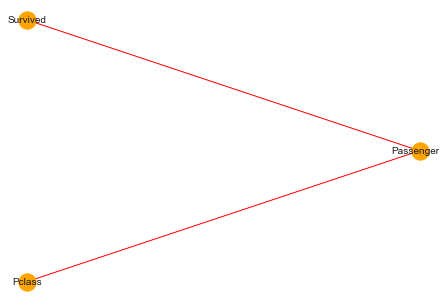

In [242]:
# Transform it in a links data frame (3 columns only):



 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network
nx.draw_circular(G, with_labels=True, node_color='orange', node_size=300, edge_color='red', linewidths=1, font_size=10)

In [263]:
df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})

/Users/harsh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


In [264]:
df.head(2)

,ID,First Name,Family Name,Phone number,Email
0,1,Felix,Revert,+33 6 12 34 56 78,felix.revert@gmail.com
1,2,Jean,Durand,+33 7 00 00 00 00,jean.durand@gmail.com


In [265]:
column_edge = 'Phone number'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

In [266]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [267]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

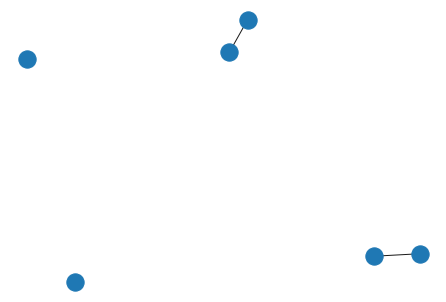

In [268]:
nx.draw(G)

In [1]:
#no